In [128]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


## Now we read the csv and see columns 

In [129]:
stori_data_source_df = pd.read_csv("Stori_Data_Challenge (6).csv")
stori_data_source_df.head()

,Unnamed: 0,cust_id,activated_date,last_payment_date,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,...,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure,fraud
0,1,C10001,2019-10-06,2020-09-09,40.900749,0.818182,95.40,0.00,95.4,0.000000,...,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,0
1,2,C10002,2019-10-06,2020-07-04,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,...,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,0
2,3,C10003,2019-10-06,2020-09-17,2495.148862,1.000000,773.17,773.17,0.0,0.000000,...,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,0
3,4,C10004,2019-10-06,2020-08-24,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,...,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12,0
4,5,C10005,2019-10-06,2020-10-20,817.714335,1.000000,16.00,16.00,0.0,0.000000,...,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,0


## 1.1 Plot an histogram of the balance amount for all the customers.

bin with more than 2500 elements :
 - frequency: 2588.0
 - Range: 0.00 a 186.70$


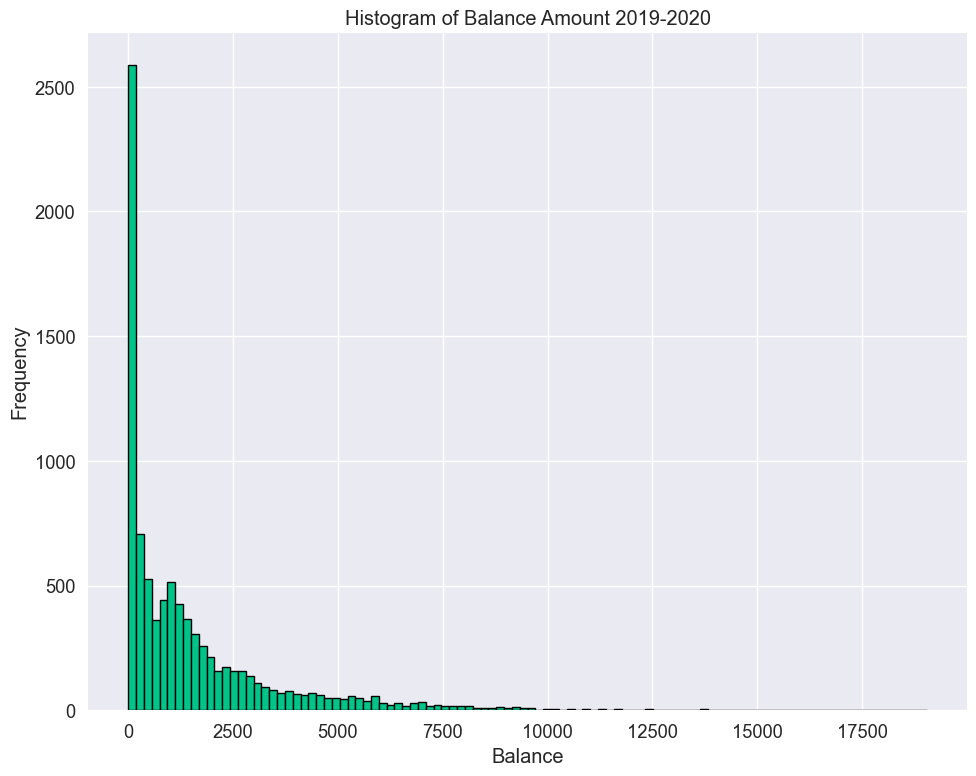

In [130]:
#let's ensure the 'balance' column is numeric
stori_data_source_df['balance'] = pd.to_numeric(stori_data_source_df['balance'])


plt.figure(figsize=(10, 8))

#in order to be able to see the distribution of the balance column we will 
#have to determine the correct number of bins

#lets use freedman's rule to determine the number of bins
x = stori_data_source_df['balance'].dropna()
q75, q25 = np.percentile(x, [75 ,25])
iqr = q75 - q25
bin_width = 2 * iqr * len(x)**(-1/3)
bins = int((x.max() - x.min()) / bin_width)



counts,bins,patches = plt.hist(stori_data_source_df['balance'], bins=bins, edgecolor='black',color="#00C38A")
plt.title('Histogram of Balance Amount 2019-2020')
plt.xlabel('Balance')
plt.ylabel('Frequency')
plt.tight_layout()

for spine in plt.gca().spines.values():
    spine.set_visible(False)

for i in range(len(counts)):
    if counts[i] > 2500:
        print(f"bin with more than 2500 elements :")
        print(f" - frequency: {counts[i]}")
        print(f" - Range: {bins[i]:.2f} a {bins[i+1]:.2f}$")
plt.show()

we can noticed that it presents a positive skewness


but maybe this skewness it's because of a pattern


## 1.2 Report any structure you find and any hypotheses you have about that structure. 

 let's create balance ranges

In [131]:


bins = [0, 200, 500,1000, 2500, 5000, 10000, 20000]
labels = ['0-200', '200-500', '500-1000','1000-2500', '2500-5000', '5000-10000', '10000-20000']

stori_data_source_df['range_balance'] = pd.cut(
    stori_data_source_df['balance'],
    bins=bins,
    labels=labels,
    right=False
)

stori_data_source_df['range_balance'] = pd.Categorical(
    stori_data_source_df['range_balance'],
    categories=labels,
    ordered=True
)

counts = stori_data_source_df['range_balance'].value_counts().sort_index()

print(counts)

range_balance
0-200          2650
200-500        1028
500-1000       1121
1000-2500      2300
2500-5000      1167
5000-10000      616
10000-20000      66
Name: count, dtype: int64



### what is the difference between accounts with balance (0-200) and (1000-2500)??


### let's see the balance_frequency grouping by range_balance

In [132]:
balance_frequency_by_range_balance_df = stori_data_source_df.groupby("range_balance")["balance_frequency"].mean().reset_index()
balance_frequency_by_range_balance_df.sort_values(by="balance_frequency", ascending=True, inplace=True)
balance_frequency_by_range_balance_df.head(10)

,range_balance,balance_frequency
0,0-200,0.684980
1,200-500,0.891800
2,500-1000,0.937615
3,1000-2500,0.973880
4,2500-5000,0.984465
5,5000-10000,0.993091
6,10000-20000,1.000000


We can conclude that there is a <b>causal relationship</b> between balance and balance frequency: when balance increases, balance frequency also increases.

<b> the account with more balance are the ones updating more frequently </b>

So, the cardholders with greater range_balance are the ones who use more their credit card? or why their balance updates more frequently?

In [133]:
purchase_frequency_by_range_balance_df = stori_data_source_df.groupby("range_balance")["purchases_frequency"].mean().reset_index()
purchase_frequency_by_range_balance_df.sort_values(by="purchases_frequency", ascending=True, inplace=True)
purchase_frequency_by_range_balance_df.head(10)

,range_balance,purchases_frequency
3,1000-2500,0.413877
4,2500-5000,0.428981
5,5000-10000,0.436926
2,500-1000,0.481019
0,0-200,0.565448
1,200-500,0.572219
6,10000-20000,0.591713


### we can notice that the accounts with balance between 1000-2500 even thought they are the top 2 in frequency, they are the most innactive purchase users with their credit cards and <b>the accounts with balance between 0-200 are most likely to buy because of their purchase frequency </b>

## let's see if they tend to buy more in installments or 1x

In [134]:

purchase_frequency_by_range_balance_df = stori_data_source_df.groupby("range_balance")[[
    "oneoff_purchases_frequency", "purchases_installments_frequency"
]].mean().reset_index()
#purchase_frequency_by_range_balance_df.sort_values(by="purchases_frequency", ascending=True, inplace=True)
purchase_frequency_by_range_balance_df.head(10)

,range_balance,oneoff_purchases_frequency,purchases_installments_frequency
0,0-200,0.139411,0.440773
1,200-500,0.296595,0.408231
2,500-1000,0.239350,0.353280
3,1000-2500,0.189465,0.298450
4,2500-5000,0.226419,0.302456
5,5000-10000,0.238990,0.331805
6,10000-20000,0.328972,0.489784


### the users with account balance between 0-200 definitely made more installments purchase but how much of their credit_limit they use in installments?

In [135]:
stori_data_source_df["installments_purchases_percentage_respect_credit_limit"] = round((stori_data_source_df["installments_purchases"] / stori_data_source_df["credit_limit"])*100,2)
stori_data_source_df["installments_purchases_percentage_respect_credit_limit"] = stori_data_source_df["installments_purchases_percentage_respect_credit_limit"].fillna(0)


purchase_frequency_by_range_balance_df = stori_data_source_df.groupby("range_balance")[[
     "purchases_installments_frequency","installments_purchases_percentage_respect_credit_limit"
]].mean().reset_index()
#purchase_frequency_by_range_balance_df.sort_values(by="purchases_frequency", ascending=True, inplace=True)
purchase_frequency_by_range_balance_df.head(10)

,range_balance,purchases_installments_frequency,installments_purchases_percentage_respect_credit_limit
0,0-200,0.440773,13.275219
1,200-500,0.408231,19.672403
2,500-1000,0.353280,14.526387
3,1000-2500,0.298450,10.875843
4,2500-5000,0.302456,7.394893
5,5000-10000,0.331805,5.882532
6,10000-20000,0.489784,13.361061


## so we can <b> conclude that the reason of the frequency of accounts with balance between 0-200 is popular because they tend to buy a high value items in installments payments resulting in few balance left in their account

## 1.3 Report mean and median balance, grouped by year and month of activated_date.  

In [136]:
stori_data_source_df['activated_date'] = pd.to_datetime(stori_data_source_df['activated_date'])


stori_data_source_df['month_activated_date'] = stori_data_source_df['activated_date'].dt.to_period('M')  

mean_and_median_balance_grouped_df = stori_data_source_df.groupby('month_activated_date')["balance"].agg(['mean','median']).reset_index()


mean_and_median_balance_grouped_df.rename(columns={"mean":"mean_balance","median":"median_balance"}, inplace=True)
mean_and_median_balance_grouped_df["mean_balance"] = round(mean_and_median_balance_grouped_df["mean_balance"], 2)
mean_and_median_balance_grouped_df["median_balance"] = round(mean_and_median_balance_grouped_df["median_balance"], 2)
mean_and_median_balance_grouped_df.head(15)

,month_activated_date,mean_balance,median_balance
0,2019-10,2482.23,1524.41
1,2019-11,1848.70,1082.07
2,2019-12,2018.79,1162.59
3,2020-01,1854.54,1175.75
4,2020-02,1747.35,994.84
5,2020-03,1554.97,828.95
6,2020-04,1483.18,910.14
7,2020-05,1214.33,734.56
8,2020-06,940.00,472.79
9,2020-07,649.72,221.29


# Question 2 



##### 2.1 Report in a table the following information for customers who activated their account and made their last payment during 2020: cust_id (excluding letters), activated_date (in format YYYY-MM), last_payment_date (in format YYYY-MM-DD),cash_advance, credit_limit, and a calculated field of cash_advance as a percentage of credit_limit.  

In [137]:
##first let's just filter the data frame 
stori_data_source_df['activated_date'] = pd.to_datetime(stori_data_source_df['activated_date'])
stori_data_source_df['last_payment_date'] = pd.to_datetime(stori_data_source_df['last_payment_date'])
customers_2020_df = stori_data_source_df.loc[(stori_data_source_df['activated_date'].dt.year == 2020)
                                              & (stori_data_source_df['last_payment_date'].dt.year == 2020)]

#now just conserve the columns we want 
customers_2020_df = customers_2020_df.filter(items=["cust_id","activated_date","last_payment_date","cash_advance","credit_limit"])
customers_2020_df["cust_id"].replace(to_replace="C", value="", regex=True, inplace=True)
customers_2020_df['activated_date'] = customers_2020_df['activated_date'].dt.strftime('%Y-%m')

##calculated field 
customers_2020_df["cash_advance_percentage_respect_credit_limit"] = round((customers_2020_df["cash_advance"] / customers_2020_df["credit_limit"])*100,2)
customers_2020_df.head()

#finally let's save it as csv file
customers_2020_df.to_csv("customer_2020.csv",index=False)



#  Question 3  


## 3.1 Build a predictive model for fraud. 


##### before starting to create a predictive model, let's see the values of the objective column ("fraud")

In [138]:
print(stori_data_source_df["fraud"].unique())

[0 1]


### so we can notice it is a <b>binary class</b> and before chossing the right algorithm we need to observe <b>if this a class imbalance problem </b>

In [139]:
print(stori_data_source_df["fraud"].value_counts())

fraud
0    8880
1      70
Name: count, dtype: int64


In [140]:
imbalance_ratio = (8880/70)*100
print(f"Imbalance ratio: {imbalance_ratio:.2f}%")

Imbalance ratio: 12685.71%


### <b>definitely it is a class imbalance problem</b>

#### so we should be careful with the algorithm selected if we want to use contrast pattern-based classifiers because we know that several contrast pattern-based classifiers do not have a good behavior with class imbalance problems due to some objects belonging to the minority class can be identified as noise

#### PBC4CIP is a good algorithm for class imbalance problems also 	SMOTE-TL + LCMine algorithm and RUSboost algorithm

In [141]:
from imblearn.ensemble import RUSBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


In [142]:

# before selecting the columns, it might be helpful to see a correlation matrix to understand how the columns influence each other
##actually not, correlation matrix is only useful for continuous variables 

#it is not helpful to include dates (they change over time) 
x = stori_data_source_df.filter(items=["balance","balance_frequency","purchases","oneoff_purchases","installments_purchases","cash_advance","purchases_frequency","oneoff_purchases_frequency","purchases_installments_frequency","cash_advance_frequency","cash_advance_trx","purchases_trx","credit_limit","payments","minimum_payments","prc_full_payment","tenure"]) 
y = stori_data_source_df['fraud']

print(x.isnull().sum())
print(y.isnull().sum())

# minium_payments NA do not have fraud rows "1"
# cash_advance NA only have 2 fraud rows "1"
# amount NA do not have fraud rows "1"
x = x.dropna()
y = y.loc[x.index] 

#stratify=1 ensure us that the split is stratified, meaning that the proportion of classes in the target variable is preserved in both the training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=45,stratify=y) 



model_RUSboost = RUSBoostClassifier(n_estimators=100, random_state=42)
model_RUSboost.fit(x_train, y_train)
y_pred = model_RUSboost.predict(x_test)



balance                               2
balance_frequency                     0
purchases                             0
oneoff_purchases                      0
installments_purchases                0
cash_advance                        112
purchases_frequency                   0
oneoff_purchases_frequency            0
purchases_installments_frequency      0
cash_advance_frequency                0
cash_advance_trx                      0
purchases_trx                         0
credit_limit                          1
payments                              0
minimum_payments                    321
prc_full_payment                      0
tenure                                0
dtype: int64
0


## results: 

[[1567  123]
 [   1   13]]


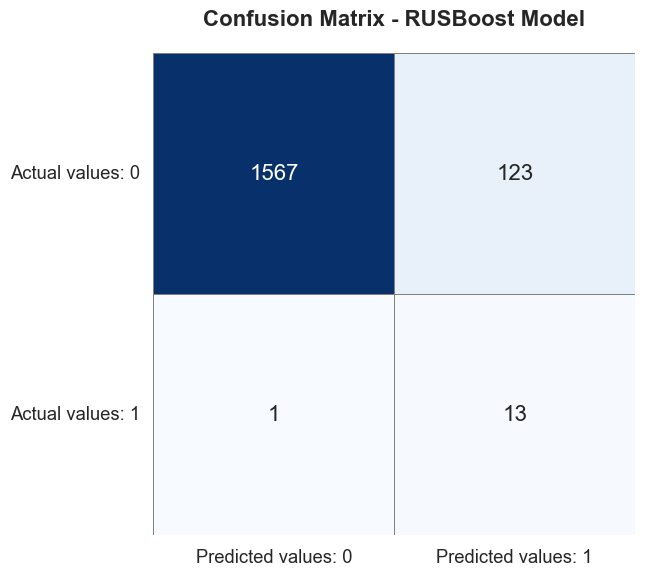

In [143]:


print(confusion_matrix(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(7, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=0.5, linecolor='gray',
            xticklabels=['Predicted values: 0', 'Predicted values: 1'],
            yticklabels=['Actual values: 0', 'Actual values: 1'],
            annot_kws={"size": 16}, square=True,cbar=False)


plt.title('Confusion Matrix - RUSBoost Model', fontsize=16, weight='bold', pad=20)



plt.xticks(rotation=0)
plt.yticks(rotation=0)


plt.tight_layout()
plt.show()

#true negative 
#false positive

#false negative
#true positive

[[1689    1]
 [   5    9]]


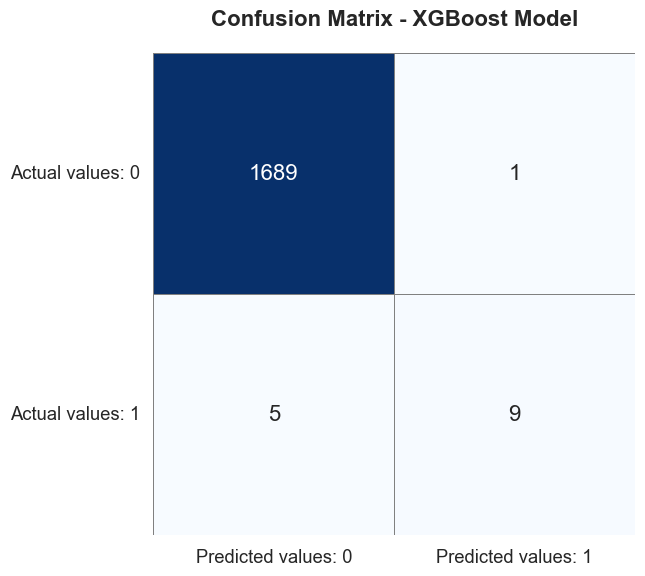

In [144]:
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x, y, test_size=0.2, random_state=45,stratify=y) 

scale = (y_train_2 == 0).sum() / (y_train_2 == 1).sum()
model_xgboost = XGBClassifier(
    scale_pos_weight=scale,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

model_xgboost.fit(x_train_2, y_train_2)
y_pred_2 = model_xgboost.predict(x_test_2)


print(confusion_matrix(y_test_2, y_pred_2))



cm = confusion_matrix(y_test_2, y_pred_2)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=0.5, linecolor='gray',
            xticklabels=['Predicted values: 0', 'Predicted values: 1'],
            yticklabels=['Actual values: 0', 'Actual values: 1'],
            annot_kws={"size": 16}, square=True,cbar=False)

plt.title('Confusion Matrix - XGBoost Model', fontsize=16, weight='bold', pad=20)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## 3.2 What explanatory variable was the most powerful predictor for fraud? 

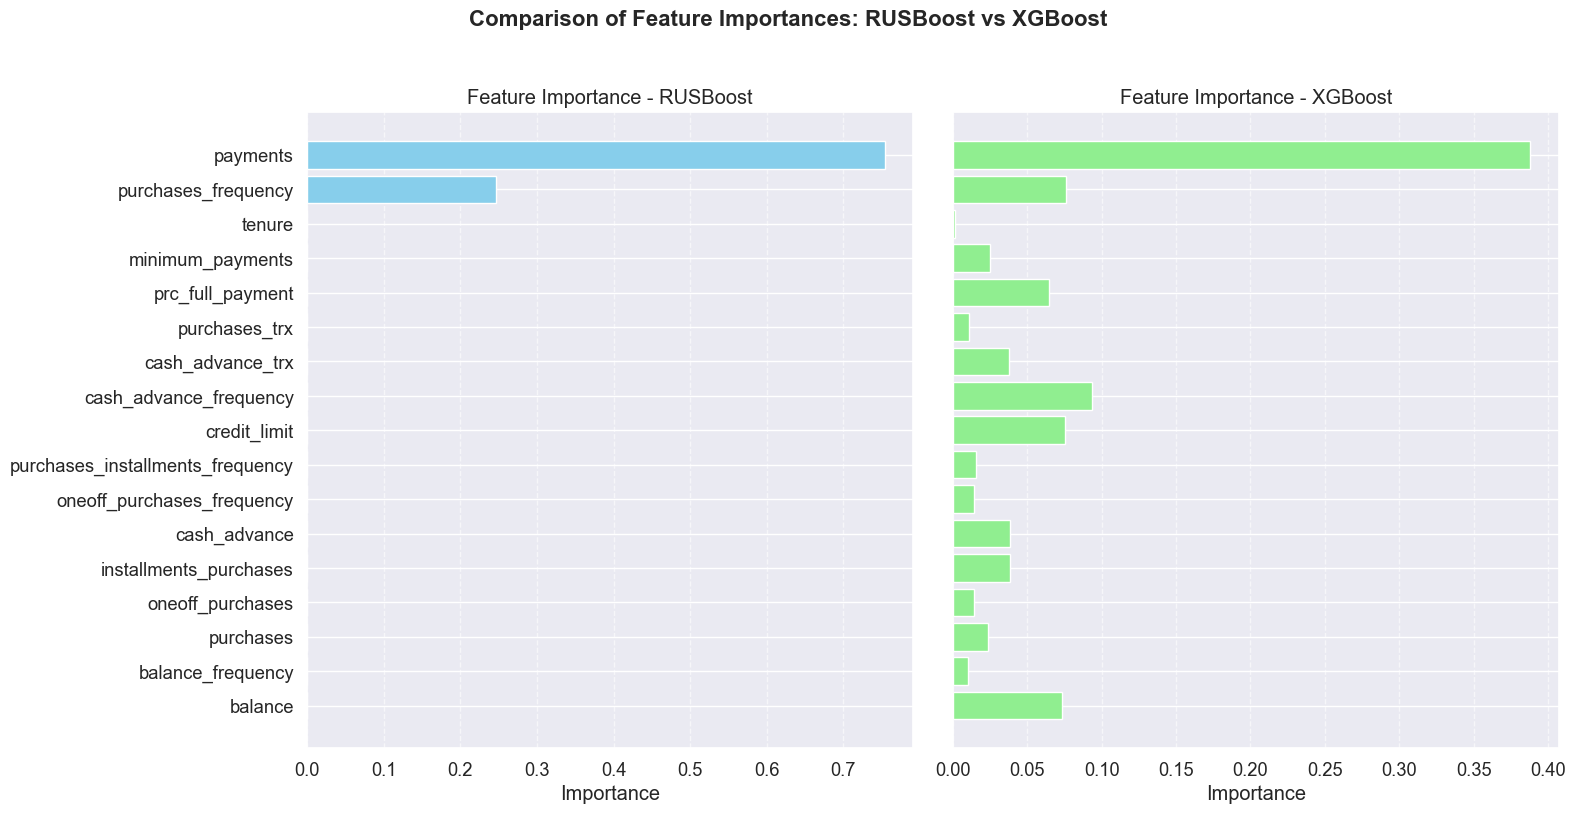

In [145]:

rus_importances = pd.Series(model_RUSboost.feature_importances_, index=x.columns).sort_values(ascending=True)
xgb_importances = pd.Series(model_xgboost.feature_importances_, index=x.columns).sort_values(ascending=True)


fig, axes = plt.subplots(ncols=2, figsize=(16, 8), sharey=True)

axes[0].barh(rus_importances.index, rus_importances.values, color='skyblue')
axes[0].set_title('Feature Importance - RUSBoost')
axes[0].set_xlabel('Importance')
axes[0].grid(axis='x', linestyle='--', alpha=0.6)

axes[1].barh(xgb_importances.index, xgb_importances.values, color='lightgreen')
axes[1].set_title('Feature Importance - XGBoost')
axes[1].set_xlabel('Importance')
axes[1].grid(axis='x', linestyle='--', alpha=0.6)

plt.suptitle('Comparison of Feature Importances: RUSBoost vs XGBoost', fontsize=16, weight='bold', y=1.02)
plt.tight_layout()
plt.show()
